In [1]:
# ==============================================================
# Random Forest Classification (RF) Experiment
# ==============================================================
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

# Plotting libraries you forgot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from preprocessing import prepare_data

# Experiment config
random_state = 42
results = []
partial_save_path = "results/rf_partial_results.csv"

In [2]:
# ---
# 1. Load Data
# ---
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print("Loaded train/test data.")

Loaded train/test data.


In [3]:
# ---
# 2. Prepare Data for TREE Models
# ---
# We MUST use mode="tree". This skips scaling and uses OrdinalEncoders.
out_train_init = prepare_data(
    train_df,
    mode="tree",
    training=False,  # We only need the encoders
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = {}  # Scalers are not used

# Prepare TEST set using the *same* "tree" mode
out_test = prepare_data(
    test_df,
    mode="tree",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

# Clean inf/-inf values
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for trees. Shape: {X_test.shape}")

Test set prepared for trees. Shape: (555719, 13)


In [4]:
# ---
# 3. Define Experiment Parameters
# ---
ratios_to_test = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
resample_types_to_test = ["df_up", "df_down"] 

params_to_test = [
    {
        "name": "RF_Depth_10",
        "params": {"n_estimators": 100, "max_depth": 10, "criterion": "gini"},
    },
    {
        "name": "RF_Full_Depth",
        "params": {"n_estimators": 100, "max_depth": None, "criterion": "gini"},
    },
]

In [5]:
# ---
# 4. Run Experiment Loop
# ---
print("\nStarting Random Forest (FULL) experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    # Get the "tree-mode" preprocessed data
    out_train = prepare_data(
        train_df,
        mode="tree",
        training=True,
        ratio=ratio,
        fit=False,  # <-- Correct: We use the fitted encoders
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            print(f"  SKIPPING {resample_type} for ratio={ratio} (no data)")
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        # Clean inf/-inf values
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        for p_info in params_to_test:
            model_name = p_info["name"]
            params = p_info["params"]
            start_k_time = time.time()

            print(f"    ⏳ Running {model_name} ...", end="")
            sys.stdout.flush()

            # n_jobs=-1 uses all your CPU cores
            model = RandomForestClassifier(random_state=random_state, n_jobs=-1, **params)
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Metrics
            f1 = f1_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob)
            prec = precision_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)

            results.append(
                {
                    "model": model_name,
                    "ratio": ratio,
                    "resample_type": resample_type.replace("df_",""), # Clean name
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                    "roc_auc": auc,
                }
            )

            print(
                f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} | Time={time.time() - start_k_time:.1f}s"
            )
            sys.stdout.flush()

    # Save partial results after each ratio
    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")

print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")


Starting Random Forest (FULL) experiment loop...

[21:08:58] Starting ratio 1/7 → ratio=None
  [21:09:01] → Training on df_up (samples=1,296,675)
    ⏳ Running RF_Depth_10 ... done → F1=0.7128, Recall=0.5641, AUC=0.9852 | Time=91.8s
    ⏳ Running RF_Full_Depth ... done → F1=0.8154, Recall=0.7072, AUC=0.9779 | Time=112.9s
  [21:12:25] → Training on df_down (samples=1,296,675)
    ⏳ Running RF_Depth_10 ... done → F1=0.7128, Recall=0.5641, AUC=0.9852 | Time=97.8s
    ⏳ Running RF_Full_Depth ... done → F1=0.8154, Recall=0.7072, AUC=0.9779 | Time=116.2s
  💾 Saved intermediate results → results/rf_partial_results.csv
  ✅ Completed ratio=None in 7.0 min

[21:15:59] Starting ratio 2/7 → ratio=0.05
  [21:16:02] → Training on df_up (samples=1,353,627)
    ⏳ Running RF_Depth_10 ... done → F1=0.7753, Recall=0.7329, AUC=0.9884 | Time=125.0s
    ⏳ Running RF_Full_Depth ... done → F1=0.8266, Recall=0.7324, AUC=0.9815 | Time=152.0s
  [21:20:39] → Training on df_down (samples=157,626)
    ⏳ Running RF

In [8]:
# ---
# 5. Show Final Results
# ---
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing Random Forest Models ---")
print(results_df.head(10))

results_df.to_csv("results/rf_results.csv", index=False)
print("\nSaved final results to results/rf_results.csv")


--- Top Performing Random Forest Models ---
            model  ratio resample_type  accuracy  precision    recall  \
17  RF_Full_Depth   0.30            up  0.998841   0.951836  0.737063   
5   RF_Full_Depth   0.05            up  0.998814   0.948671  0.732401   
13  RF_Full_Depth   0.20            up  0.998809   0.948036  0.731469   
9   RF_Full_Depth   0.10            up  0.998803   0.945247  0.732401   
21  RF_Full_Depth   0.50            up  0.998803   0.949029  0.729138   
25  RF_Full_Depth   1.00            up  0.998776   0.944209  0.725874   
1   RF_Full_Depth    NaN            up  0.998764   0.962563  0.707226   
3   RF_Full_Depth    NaN          down  0.998764   0.962563  0.707226   
7   RF_Full_Depth   0.05          down  0.998267   0.762900  0.799534   
4     RF_Depth_10   0.05            up  0.998361   0.823037  0.732867   

          f1   roc_auc  
17  0.830793  0.981302  
5   0.826625  0.981511  
13  0.825789  0.981173  
9   0.825322  0.980438  
21  0.824677  0.980492  
2


Generating plots...


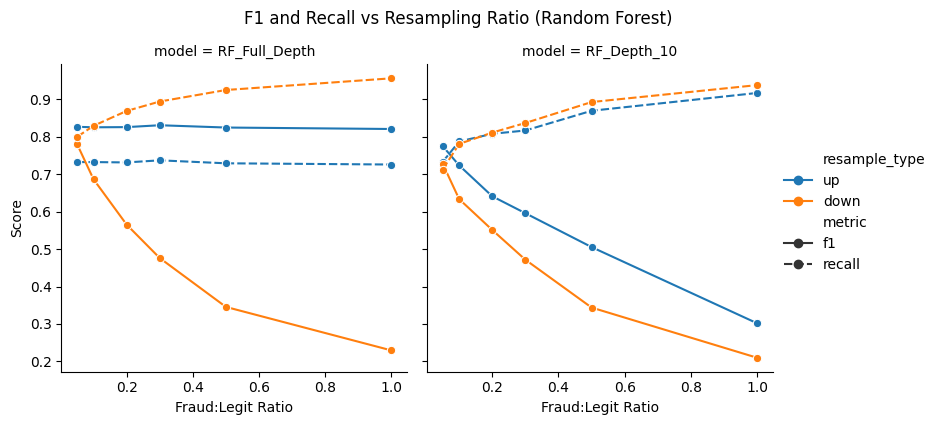

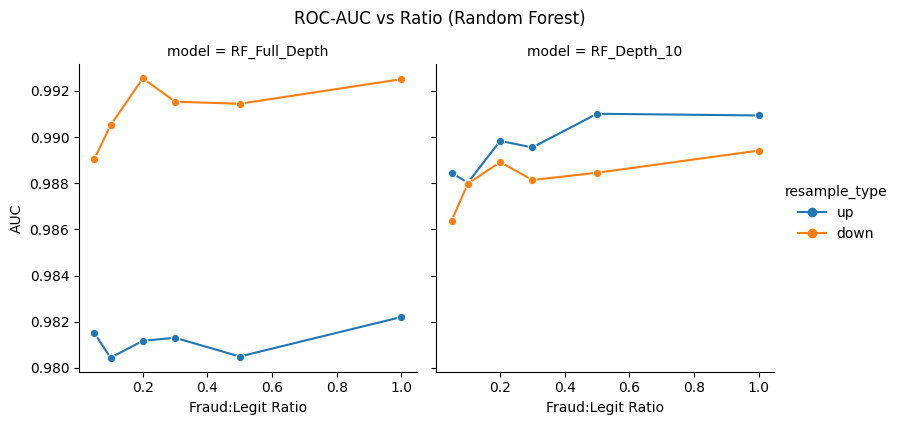


--- Mean Scores Summary ---
                                   precision  recall     f1  roc_auc
model         ratio resample_type                                   
RF_Depth_10   0.05  down               0.745   0.712  0.728    0.986
                    up                 0.823   0.733  0.775    0.988
              0.10  down               0.533   0.781  0.634    0.988
                    up                 0.669   0.787  0.723    0.988
              0.20  down               0.417   0.811  0.551    0.989
                    up                 0.531   0.808  0.641    0.990
              0.30  down               0.328   0.837  0.472    0.988
                    up                 0.469   0.817  0.596    0.990
              0.50  down               0.213   0.893  0.344    0.988
                    up                 0.356   0.869  0.505    0.991
              1.00  down               0.118   0.938  0.210    0.989
                    up                 0.181   0.917  0.302    0.991
RF_Fu

In [9]:
# ---
# 6. Plot Results
# ---
if not results_df.empty:
    print("\nGenerating plots...")
    
    # ---- Plot F1 & Recall vs Ratio (faceted by model) ----
    
    # Melt for easier plotting with seaborn
    df_melt = results_df.melt(id_vars=['ratio', 'resample_type', 'model'], value_vars=['f1', 'recall'],
                              var_name='metric', value_name='score')

    # Use sns.relplot() to create a FacetGrid
    g_f1 = sns.relplot(
        data=df_melt,
        x="ratio",
        y="score",
        hue="resample_type",
        style="metric",
        col="model",
        kind="line",
        marker="o",
        height=4,
        aspect=1
    )
    g_f1.fig.suptitle("F1 and Recall vs Resampling Ratio (Random Forest)", y=1.05)
    g_f1.set_axis_labels("Fraud:Legit Ratio", "Score")
    g_f1.savefig("results/rf_f1_recall_plot.png")
    plt.show()

    # ---- Plot ROC-AUC vs Ratio (faceted by model) ----
    
    g_auc = sns.relplot(
        data=results_df,
        x="ratio",
        y="roc_auc",
        hue="resample_type",
        col="model",
        kind="line",
        marker="o",
        height=4,
        aspect=1
    )
    g_auc.fig.suptitle("ROC-AUC vs Ratio (Random Forest)", y=1.05)
    g_auc.set_axis_labels("Fraud:Legit Ratio", "AUC")
    g_auc.savefig("results/rf_auc_plot.png")
    plt.show()
    
    # ---- Summary Table ----
    summary = results_df.groupby(["model", "ratio", "resample_type"])[["precision", "recall", "f1", "roc_auc"]].mean().round(3)
    print("\n--- Mean Scores Summary ---")
    print(summary)

    print("\nPlots and summary complete.")
else:
    print("No results to plot.")